In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/dfu_features_dataset.csv', index_col=0)

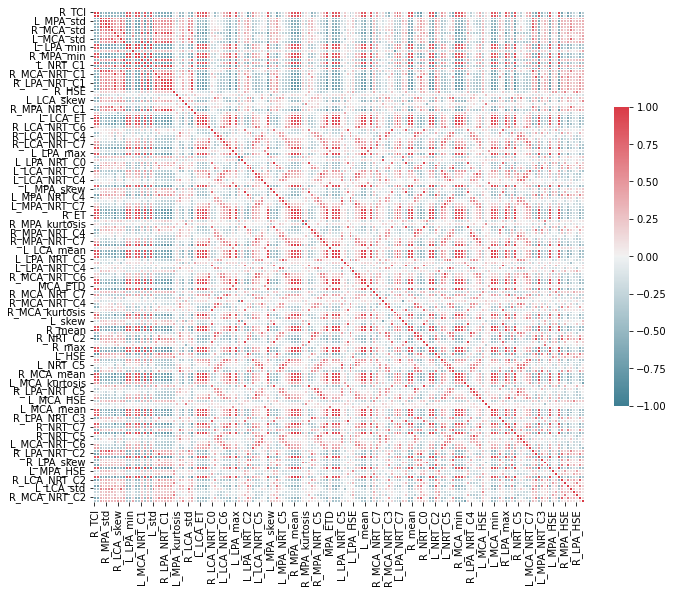

In [36]:
# matplolib for showing the correlation between variables
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df.corr(), cmap=cmap, vmax=1., vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# Correlation between Control Group and Diabetic

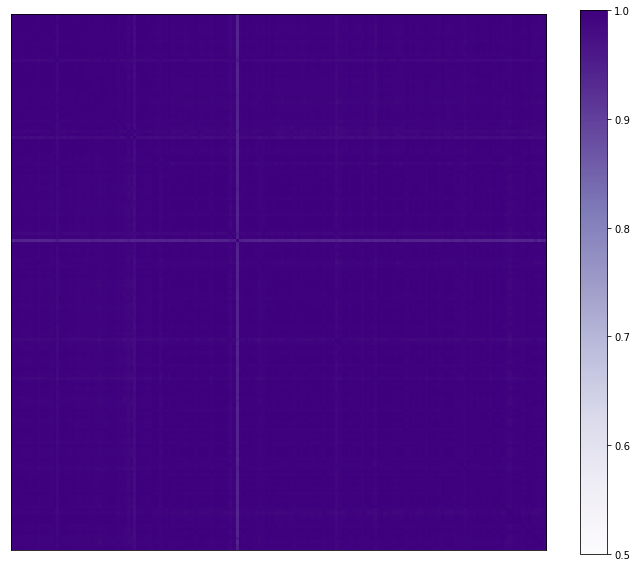

In [30]:
# filter dataframe by index prefix
cg_group = df.filter(regex='^CG', axis=0).to_numpy()
dm_group = df.filter(regex='^DM', axis=0).to_numpy()

# calculate the correlation between two groups
import numpy as np
corr = np.corrcoef(cg_group, dm_group)

# Plot correlation matrix
plt.figure(figsize=(12, 10))
plt.imshow(corr, cmap='Purples', vmin=.5, vmax=1, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

# Compute ROC-AUC score

In [6]:
X = np.concatenate((cg_group, dm_group), axis=0)
y = np.concatenate((np.zeros(cg_group.shape[0]), np.ones(dm_group.shape[0])))

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import numpy as np

roc_auc = np.zeros(X.shape[1])

for feature in range(X.shape[1]):
    _X = np.expand_dims(X[:,feature], axis=1)
    clf = LogisticRegression(solver="liblinear", random_state=0).fit(_X, y)
    y_hat = np.argmax(clf.predict_proba(_X), axis=1)
    roc_auc[feature] = roc_auc_score(y, y_hat)

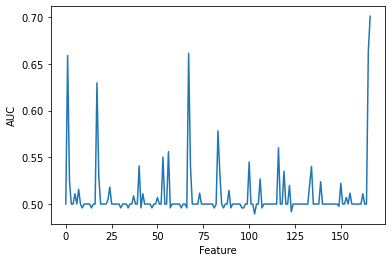

In [8]:
from matplotlib import pyplot as plt 

plt.plot(roc_auc)
plt.xlabel('Feature')
plt.ylabel('AUC')
plt.show()

# Remove high-correlated features

In [9]:
# Sorted by Feature Ranking based on ROC-AUC
df = df.iloc[:,roc_auc.argsort()[::-1]]
df.head()

,R_TCI,L_TCI,L_LPA_std,L_MPA_std,R_MPA_std,R_LPA_std,R_MCA_std,R_LCA_NRT_C1,R_LCA_skew,L_MCA_std,...,R_LCA_HSE,R_LPA_ET,R_LCA_NRT_C2,R_MPA_HSE,L_MCA_NRT_C2,L_LCA_std,L_LCA_HSE,R_LPA_HSE,R_MCA_NRT_C2,L_MCA_skew
Subject,,,,,,,,,,,,,,,,,,,,,
CG001_M,0.118606,0.463984,1.687506,1.845612,1.830448,1.521421,1.140813,0.591164,0.539783,1.040803,...,0.751037,24.544236,0.253857,0.507843,0.151751,0.805580,0.608923,0.544236,0.166348,0.473113
CG002_M,1.973097,2.088571,1.388839,1.411418,1.381560,1.345334,1.240519,0.003722,0.777527,1.147133,...,0.165478,28.211031,0.303970,0.013774,0.139286,1.026709,0.056851,0.288969,0.181882,-0.281261
CG003_M,3.788465,3.570597,1.521142,1.309371,0.951396,1.202043,0.984406,0.000000,0.322632,0.930011,...,0.342492,29.193977,0.000000,0.036285,0.000000,0.770409,0.255063,0.306023,0.000000,-0.138314
CG004_F,1.818169,1.498769,1.778043,2.046408,1.854106,1.596353,1.395944,0.059987,0.221590,1.462168,...,0.034215,27.641521,0.208679,0.145053,0.241254,0.987146,0.008821,0.141521,0.161775,0.190562
CG005_F,0.287098,0.810626,1.701351,1.851659,1.851993,1.586253,1.243114,0.347585,-0.090335,1.181013,...,0.735520,24.595411,0.396675,0.635714,0.251712,0.964827,0.279428,0.595411,0.286268,-0.174162


In [37]:
import numpy as np

def select_features(df, threshold=.95):
    '''
        Select the features and remove those which have a high correlation factor.

        The features are selected taking into account the order of the features, i.e.,
        if three features are highly-correlated, the first one is selected and the
        other two are removed. For this reason, it is important the order of the features
        is sorted by the feature ranking such as, for instance, ROC-AUC.

        Parameters
        ----------
        df : pandas.DataFrame
            Dataframe which contains the dataset

        threshold : float
            Threshold for the correlation factor

        Returns
        -------
        selected_features : list
            List of selected features
    '''

    tmp_df = df.copy()
    mask = np.ones(len(tmp_df.columns), dtype=bool)
    selected_features = []

    while mask.sum() > 0:
        tmp_df = tmp_df.iloc[:,mask]
        mask = np.ones(len(tmp_df.columns), dtype=bool)
        corr = tmp_df.corr().abs().to_numpy()
        
        selected_features.append(tmp_df.columns[0])

        corr_with_current_feature = corr[0,:]
        idx = np.argwhere(corr_with_current_feature > .95).flatten()

        mask[idx] = False

    return selected_features


selected_features = select_features(df, threshold=.95)

In [38]:
df[selected_features].head()

,R_TCI,L_TCI,L_LPA_std,L_MPA_std,R_MPA_std,R_LPA_std,R_MCA_std,R_LCA_NRT_C1,R_LCA_skew,L_MCA_std,...,L_MPA_HSE,R_LCA_HSE,R_LCA_NRT_C2,R_MPA_HSE,L_MCA_NRT_C2,L_LCA_std,L_LCA_HSE,R_LPA_HSE,R_MCA_NRT_C2,L_MCA_skew
Subject,,,,,,,,,,,,,,,,,,,,,
CG001_M,0.118606,0.463984,1.687506,1.845612,1.830448,1.521421,1.140813,0.591164,0.539783,1.040803,...,0.441441,0.751037,0.253857,0.507843,0.151751,0.805580,0.608923,0.544236,0.166348,0.473113
CG002_M,1.973097,2.088571,1.388839,1.411418,1.381560,1.345334,1.240519,0.003722,0.777527,1.147133,...,0.190840,0.165478,0.303970,0.013774,0.139286,1.026709,0.056851,0.288969,0.181882,-0.281261
CG003_M,3.788465,3.570597,1.521142,1.309371,0.951396,1.202043,0.984406,0.000000,0.322632,0.930011,...,0.051890,0.342492,0.000000,0.036285,0.000000,0.770409,0.255063,0.306023,0.000000,-0.138314
CG004_F,1.818169,1.498769,1.778043,2.046408,1.854106,1.596353,1.395944,0.059987,0.221590,1.462168,...,1.079327,0.034215,0.208679,0.145053,0.241254,0.987146,0.008821,0.141521,0.161775,0.190562
CG005_F,0.287098,0.810626,1.701351,1.851659,1.851993,1.586253,1.243114,0.347585,-0.090335,1.181013,...,1.048780,0.735520,0.396675,0.635714,0.251712,0.964827,0.279428,0.595411,0.286268,-0.174162
